### Subset and store  MSI datasets to top20, top10 and top5 most spatially variable metabolites

In [4]:
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import squidpy as sq
from sklearn.preprocessing import StandardScaler
# from sklearn import model_selection
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os


In [24]:
#Set path to data
# path_msi = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.MSI_MOSCOT_paired_hvg.h5ad"
path_msi = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/MSI_concat_lipids.h5ad"


# Set task/dataset name and path to store (keep MSI in the name since it will be used for storing, to differentiate from RNA)
dataset_name  = "V11L12-038_A1.MSI_MOSCOT_paired_hvg"
store_dir = "/lustre/groups/ml01/workspace/eirini.giannakoulia/hand_prep/"
# name of final data will be a combination of task_name and topN abundant metabs

In [25]:
adata_msi_full = sc.read_h5ad(path_msi)
# adata_rna_full = sc.read_h5ad(path_rna)

/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Prepare MSI data

In [26]:
adata_msi_full

AnnData object with n_obs × n_vars = 5618 × 2754
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
adata_msi_full.var_names_make_unique()

In [9]:
adata_msi_full

AnnData object with n_obs × n_vars = 5618 × 2754
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

#### Quality control (uncomment for unprocessed datasets)

Here you can subset metabolites for noise  
e.g.:  
Remove m/z below FMP10, because most likely this is noise:  
```python
adata_msi_full.var_names  
adata_msi = adata_msi_full[:, adata_msi_full.var_names.astype(float) > 288.15].copy()

In [10]:
# adata_msi = adata_msi_full[:, adata_msi_full.var_names.astype(float) > 288.15].copy()
adata_msi = adata_msi_full.copy()
adata_msi

AnnData object with n_obs × n_vars = 5618 × 2754
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
sc.pp.calculate_qc_metrics(adata_msi, inplace=True)


<Axes: xlabel='total_counts', ylabel='Count'>

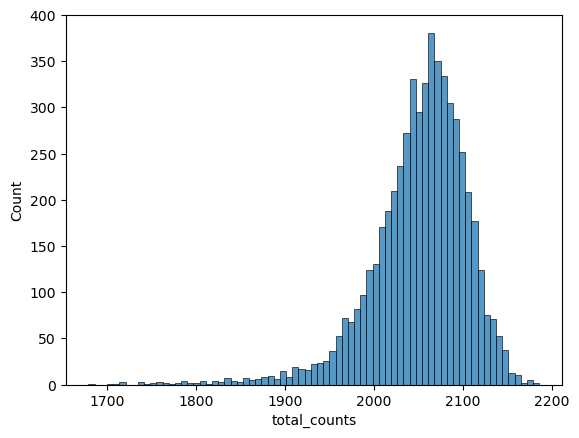

In [14]:
sns.histplot(adata_msi.obs.total_counts) #This sums all the metabolites counted for each cell. 


<Axes: xlabel='n_cells_by_counts', ylabel='Count'>

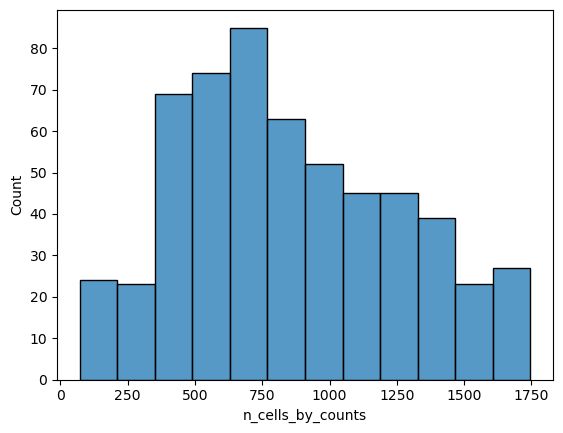

In [15]:
sns.histplot(adata_msi.var.n_cells_by_counts) #This sums # of cells in which each metabolite m/z ratio was found


In [16]:
adata_msi.var.n_cells_by_counts.describe()


count     569.000000
mean      854.485062
std       403.423868
min        71.000000
25%       549.000000
50%       785.000000
75%      1157.000000
max      1747.000000
Name: n_cells_by_counts, dtype: float64

In [20]:
# Remove highly abundant (since they are most likely noise)
desc = adata_msi.var.n_cells_by_counts.describe()
# Extract the 75% value, then round up to the nearest 50
max_cells_val = int(np.ceil(desc['75%'] / 50.0) * 50)

sc.pp.filter_genes(adata_msi, max_cells=max_cells_val)
#or alternatively seet your own number:
# sc.pp.filter_genes(adata_msi, max_cells=1750)


/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


#### Let's identify most spatialy variable metabolites

In [21]:
adata_msi

AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

MoranI already present, but just for completeness let's go for the procedure from beginning



In [22]:
# Identify top 5 most spatially variable metabolomes using Moran's I
sq.gr.spatial_neighbors(adata_msi, spatial_key='spatial_warp')
sq.gr.spatial_autocorr(adata_msi)


Do a sorting based first on index, then on Benjamini Hochberg FDR correction pvalue and select the top 30

In [23]:
adata_msi.uns["moranI"]

,I,pval_norm,var_norm,pval_norm_fdr_bh
203.05299000000002,0.728759,0.000000,0.000113,0.000000
162.11293999999998,0.720096,0.000000,0.000113,0.000000
214.01164,0.692849,0.000000,0.000113,0.000000
280.092375,0.690487,0.000000,0.000113,0.000000
845.51016,0.678208,0.000000,0.000113,0.000000
...,...,...,...,...
757.524185,-0.012857,0.120397,0.000113,0.131438
955.885645,-0.013307,0.112128,0.000113,0.122678
985.53971,-0.015396,0.079038,0.000113,0.087626
889.700055,-0.016634,0.063264,0.000113,0.070924


In [24]:
top_30_spat = adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].sort_values(by=["I", "pval_norm_fdr_bh"], ascending=[False, True]).index[:30]


#### Mini correction for known DHB positive mode matrix peaks, if info for other matrices/modes add the values

In [25]:
mz_values = adata_msi.var_names.astype(float).to_numpy()
mz_values

In [ ]:
dhb_peaks_positive = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
found_peaks = set(mz_values[np.abs(mz_values[:, None] - dhb_peaks_positive[None, :]).min(axis=1) <= 0.1])
found_peaks_str = set(map(str, found_peaks))

# dhb_peaks_negative = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - dhb_peaks_negative[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))

# fmp10_peaks_positive = np.array([])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - fmp10_peaks_positive[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))

# fmp10_peaks_negative = np.array([])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - fmp10_peaks_negative[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))

top_30_spat_filtered = [mz for mz in top_30_spat if mz not in found_peaks_str]
print(top_30_spat_filtered, len(top_30_spat_filtered), found_peaks)


In [ ]:
# #If you dont want to do the matrix peaks cleaning, just comment out previous part and uncomment this:
# top_30_spat_filtered = top_30_spat

In [ ]:
top_5_spat_metabolites = top_30_spat_filtered[:5]
top_10_spat_metabolites = top_30_spat_filtered[:10]
top_20_spat_metabolites = top_30_spat_filtered[:20]
# adata_msi_top5_spat = adata_msi[:, adata_msi.var_names.isin(top_5_spat_metabolites)].copy()
adata_msi_top10_spat = adata_msi[:, adata_msi.var_names.isin(top_10_spat_metabolites)].copy()
adata_msi_top20_spat = adata_msi[:, adata_msi.var_names.isin(top_20_spat_metabolites)].copy()

#### Store the created dataset full in the directory of choice, under {original_dataset_name}_topNspatvar.h5ad

In [ ]:
# adata_msi_top5_spat.write(os.path.join(store_dir, f"{dataset_name}_top5spatvar.h5ad"))
adata_msi_top10_spat.write(os.path.join(store_dir, f"{dataset_name}_top10spatvar.h5ad"))
adata_msi_top20_spat.write(os.path.join(store_dir, f"{dataset_name}_top20spatvar.h5ad"))

In [33]:
# adata_msi_top5_spat

### Processed Dataset Setup for Feature Selection

The following instructions explain how to avoid re-preprocessing the data in the main pipeline. The `run_featsel` step will skip preprocessing if the data already exists in the output directory of the `feat_sel` rule.

### Steps

1. **Manually Create Processed Datasets**

   - Copy the processed RNA test and train splits from the corresponding RNA dataset (choose one from *vitatrack*, *neuro*, or *lipids*).

2. **Place Data in the Pipeline Directory**

   - Copy the processed datasets from the previous step into the pipeline's workspace directory.
   - Rename the folder as needed (e.g., using the task name specified in `config.yaml`):
     
     ```bash
     /lustre/groups/ml01/workspace/eirini.giannakoulia/{task_name}_topN_spatvar
     ```

3. **Add Processed MSI Data**

   - Run the remaining notebook to add the processed MSI data into all the feature selection folders

3. **Paste in pipeline**

   - Paste under:
   ```bash
     pipeline/dataset/processed/{task_name}_topN_spatvar
     ```




After completing these steps, your pipeline is ready to run without reprocessing the data.


In [46]:
task_name = "V11L12-038_A1_MOSCOT_paired_hvg"
split = "split"

In [47]:
# base_dir = f"/lustre/groups/ml01/workspace/eirini.giannakoulia/{task_name}_top5_spatvar"
# adata_msi_top5_spat_train = adata_msi_top5_spat[adata_msi_top5_spat.obs["half_split" ]== "train"].copy()
# adata_msi_top5_spat_test = adata_msi_top5_spat[adata_msi_top5_spat.obs["half_split" ]== "test"].copy()

# for feat_sel in ["hvg", "hvg_svd", "hvg_svd_graph", "svd", "svd_graph"]:
#     adata_msi_top5_spat_train.write(os.path.join("/lustre/groups/ml01/workspace/eirini.giannakoulia/lipids_top5_spatvar",feat_sel,"msi_dataset_train.h5ad"))
#     adata_msi_top5_spat_test.write(os.path.join("/lustre/groups/ml01/workspace/eirini.giannakoulia/lipids_top5_spatvar",feat_sel,"msi_dataset_test.h5ad"))


In [ ]:
base_dir = f"/lustre/groups/ml01/workspace/eirini.giannakoulia/{task_name}_top10_spatvar"
adata_msi_top10_spat_train = adata_msi_top10_spat[adata_msi_top10_spat.obs[split]=="train"].copy()
adata_msi_top10_spat_test = adata_msi_top10_spat[adata_msi_top10_spat.obs[split]=="test"].copy()

for feat_sel in ["hvg", "hvg_svd", "hvg_svd_graph", "svd", "svd_graph"]:
    # Create the directory if it doesn't exist
    out_dir = os.path.join(base_dir, feat_sel)
    os.makedirs(out_dir, exist_ok=True)

    # Write the files
    adata_msi_top10_spat_train.write(os.path.join(out_dir, "msi_dataset_train.h5ad"))
    adata_msi_top10_spat_test.write(os.path.join(out_dir, "msi_dataset_test.h5ad"))


In [50]:
adata_msi_top10_spat

AnnData object with n_obs × n_vars = 2681 × 10
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [51]:
base_dir = f"/lustre/groups/ml01/workspace/eirini.giannakoulia/{task_name}_top20_spatvar"

adata_msi_top20_spat_train = adata_msi_top20_spat[adata_msi_top20_spat.obs[split]=="train"].copy()
adata_msi_top20_spat_test = adata_msi_top20_spat[adata_msi_top20_spat.obs[split]=="test"].copy()


In [ ]:
# Cross check if var size is correct
adata_msi_top20_spat_train


In [ ]:
for feat_sel in ["hvg", "hvg_svd", "hvg_svd_graph", "svd", "svd_graph"]:
    out_dir = os.path.join(base_dir, feat_sel)
    os.makedirs(out_dir, exist_ok=True)
    
    adata_msi_top20_spat_train.write(os.path.join(out_dir, "msi_dataset_train.h5ad"))
    adata_msi_top20_spat_test.write(os.path.join(out_dir, "msi_dataset_test.h5ad"))
